# Using the Wisconsin breast cancer diagnostic data set for predictive analysis
Attribute Information:

 - 1) ID number 
 - 2) Diagnosis (M = malignant, B = benign) 
 
-3-32.Ten real-valued features are computed for each cell nucleus:

 - a) radius (mean of distances from center to points on the perimeter) 
 - b) texture (standard deviation of gray-scale values) 
 - c) perimeter 
 - d) area 
 - e) smoothness (local variation in radius lengths) 
 - f) compactness (perimeter^2 / area - 1.0) 
 - g). concavity (severity of concave portions of the contour) 
 - h). concave points (number of concave portions of the contour) 
 - i). symmetry 
 - j). fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.


For this analysis, as a guide to predictive analysis I followed the instructions and discussion on "A Complete Tutorial on Tree Based Modeling from Scratch (in R & Python)" at Analytics Vidhya.

#Load Libraries

In [1]:
import numpy as np 
import pandas as pd 


%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec 
import mpld3 as mpl


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

# Load the data

In [2]:
df = pd.read_csv("../input/data.csv",header = 0)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


# Clean and prepare data

In [3]:
df.drop('id',axis=1,inplace=True)
df.drop('Unnamed: 32',axis=1,inplace=True)
len(df)

569

In [4]:
df.diagnosis.unique()

array(['M', 'B'], dtype=object)

In [5]:
#Convert 
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.head()

# Explore data

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [6]:
df.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


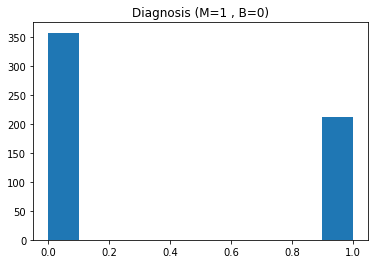

In [7]:
df.describe()
plt.hist(df['diagnosis'])
plt.title('Diagnosis (M=1 , B=0)')
plt.show()

### nucleus features vs diagnosis

In [8]:
features_mean=list(df.columns[1:11])
# split dataframe into two based on diagnosis
dfM=df[df['diagnosis'] ==1]
dfB=df[df['diagnosis'] ==0]

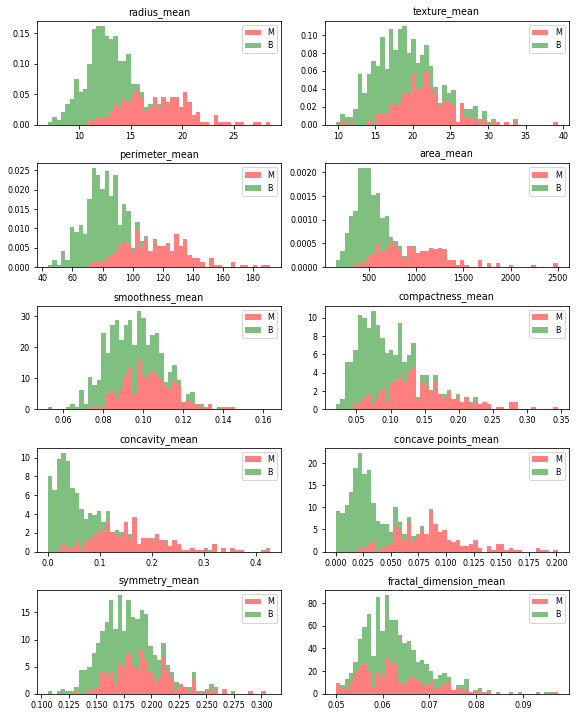

In [9]:

plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8,10))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(df[features_mean[idx]]) - min(df[features_mean[idx]]))/50  
    ax.hist([dfM[features_mean[idx]],dfB[features_mean[idx]]], alpha=0.5,stacked=True, label=['M','B'],color=['r','g'],bins=np.arange(min(df[features_mean[idx]]), max(df[features_mean[idx]]) + binwidth, binwidth) , density = True,)
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

### Observations

1. mean values of cell radius, perimeter, area, compactness, concavity and concave points can be used in classification of the cancer. Larger values of these parameters tends to show a correlation with malignant tumors. 
2. mean values of texture, smoothness, symmetry or fractual dimension does not show a particular preference of one diagnosis over the other. In any of the histograms there are no noticeable large outliers that warrants further cleanup.

## Creating a test set and a training set
Since this data set is not ordered, I am going to do a simple 70:30 split to create a training data set and a test data set.

In [10]:
traindf, testdf = train_test_split(df, test_size = 0.3)

## Model Building

Here we are going to build a classification model and evaluate its performance using the training set.



# Naive Bayes model

In [11]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean']
outcome_var='diagnosis'

In [12]:

model.fit(traindf[predictor_var],traindf[outcome_var])
predictions = model.predict(traindf[predictor_var])
accuracy = metrics.accuracy_score(predictions,traindf[outcome_var])
print("Accuracy : %s" % "{0:.3%}".format(accuracy))

Accuracy : 89.698%


<AxesSubplot:>

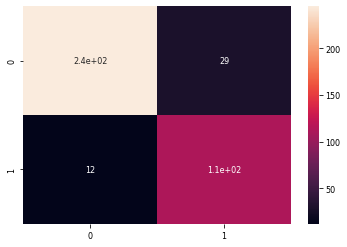

In [13]:
import seaborn as sns
sns.heatmap(metrics.confusion_matrix(predictions,traindf[outcome_var]),annot=True)

In [14]:
from sklearn.model_selection import cross_val_score
from statistics import mean
print(mean(cross_val_score(model, traindf[predictor_var],traindf[outcome_var], cv=5))*100)

89.94303797468355
